In [134]:
from helpers_given import *
from preprocess import *
from helpers import *

Load data with helpers_given

In [88]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("dataset/", sub_sample=False)

y_train loaded
x_train loaded
x_test loaded


In [89]:
nb_col = x_train.shape[1]
nb_rows = x_train.shape[0]
print(nb_col)
print(nb_rows)

321
328135


In [90]:
y_01 = convert_minus1_to_0(y_train)

In [91]:
print(y_01)
print(y_01[y_01==0].shape)
print(y_01[y_01==1].shape)

[0. 0. 0. ... 0. 0. 0.]
(299160,)
(28975,)


In [92]:
with open('dataset/x_train.csv', 'r') as f:
    features_string = f.readline()
    features = features_string.split(',')
features = features[1:]

Preprocessing of run.py

In [93]:
nb_nans = np.zeros(nb_col)
for i, col in enumerate(x_train.T):
    nb_nans[i] = np.count_nonzero(np.isnan(col))

In [94]:
#nb_nans = number_of_NaNs(features, x_train)
reduced_data, reduced_features, Removed_features = removing_features(nb_nans, features, x_train)
#need to apply the same transfo to x_test
reduced_test = np.delete(x_test, Removed_features, 1)

In [95]:
# Get feature correlation dictionary
feature_correlation_dict = create_dictionary_from_correlation(reduced_data,reduced_features,0.6)

max_corrr_feature_dict = {}

# Find the 50 most correlated features
for key, val in feature_correlation_dict.items():
    max_corrr_feature_dict[key] = len(val)

 Finished for feature: _STATE
 Finished for feature: FMONTH
 Finished for feature: IDATE
 Finished for feature: IMONTH
 Finished for feature: IDAY
 Finished for feature: IYEAR
 Finished for feature: DISPCODE
 Finished for feature: SEQNO
 Finished for feature: _PSU
 Finished for feature: GENHLTH
 Finished for feature: PHYSHLTH
 Finished for feature: MENTHLTH
 Finished for feature: HLTHPLN1
 Finished for feature: PERSDOC2
 Finished for feature: MEDCOST
 Finished for feature: CHECKUP1
 Finished for feature: BPHIGH4
 Finished for feature: BLOODCHO
 Finished for feature: CVDSTRK3
 Finished for feature: ASTHMA3
 Finished for feature: CHCSCNCR
 Finished for feature: CHCOCNCR
 Finished for feature: CHCCOPD1
 Finished for feature: HAVARTH3
 Finished for feature: ADDEPEV2
 Finished for feature: CHCKIDNY
 Finished for feature: DIABETE3
 Finished for feature: SEX
 Finished for feature: MARITAL
 Finished for feature: EDUCA
 Finished for feature: RENTHOM1
 Finished for feature: VETERAN3
 Finished fo

In [96]:
# Sort the dictionary by value in descending order
max_corrr_feature_dict = {k: v for k, v in sorted(max_corrr_feature_dict.items(), key=lambda item: item[1], reverse=True)}

features_to_drop = []
for key in max_corrr_feature_dict.keys():
    features_to_drop.append(key)
    if len(features_to_drop) == 44:
        break

# Define features to keep
features_to_keep = []
for feature in reduced_features:
    if feature not in features_to_drop:
        features_to_keep.append(feature)

# Also replace some features with their calculated counterparts
origin_calculated_features = {
    'WEIGHT2' : 'WTKG3',
    'HEIGHT3' : 'HTM4',
    'ALCDAY5' : '_DRNKWEK',
    'FRUITJU1' : 'FTJUDA1_',
    'FRUIT1' : 'FRUTDA1_',
    'FVBEANS' : 'BEANDAY_',
    'FVGREEN' : 'GRENDAY_',
    'FVORANG' : 'ORNGDAY_',
    'VEGETAB1' : 'VEGEDA1_',
    'STRENGTH' : 'STRFREQ_'
}

# In features_to_keep replace the key of origin_calculated_features with the value
for key, val in origin_calculated_features.items():
    for i, feature in enumerate(features_to_keep):
        if key == feature:
            features_to_keep[i] = val

# Drop duplicates
features_to_keep = list(set(features_to_keep))

# Get the indices of the selected features
selected_features_indices = []
for feature in features_to_keep:
    selected_features_indices.append(reduced_features.index(feature))

selected_features_indices = sorted(selected_features_indices)

# Create a new dataset with keeping the features that are in the selected_features_indices
reduced_data = reduced_data[:,selected_features_indices]
reduced_test = reduced_test[:,selected_features_indices]

# Also remove the features from the reduced_features list
reduced_features_2 = []
for feature in reduced_features:
    if feature in features_to_keep:
        reduced_features_2.append(feature)

# Remove redundant features
redundant_features = [ 'FMONTH','IDATE','IMONTH','IDAY','IYEAR', 'SEQNO', '_STATE', '_PSU', ]
# Get the indices of these features
redundant_features_indices = []
for feature in redundant_features:
    redundant_features_indices.append(reduced_features_2.index(feature))

# Create a new dataset with removing the features that are in the selected_features_indices
reduced_data = np.delete(reduced_data, redundant_features_indices, 1)
reduced_features_2 = [reduced_features_2[i] for i in range(len(reduced_features_2)) if i not in redundant_features_indices]
reduced_test = np.delete(reduced_test, redundant_features_indices, 1)

# Replace nine values with NaNs
replace_nine_with_nan(reduced_data)
replace_nine_with_nan(reduced_test)

# Replace seven values with NaNs
replace_seven_with_nan(reduced_data)
replace_seven_with_nan(reduced_test)

# Replace 99 values with NaNs
replace_99_with_nan(reduced_data)
replace_99_with_nan(reduced_test)

# For the _DRNKWEK feature, replace 9990 with NaN
for i in range(reduced_data.shape[0]):
    if reduced_data[i, reduced_features_2.index('_DRNKWEK')] == 9990:
        reduced_data[i, reduced_features_2.index('_DRNKWEK')] = np.nan
for i in range(reduced_test.shape[0]):
    if reduced_test[i, reduced_features_2.index('_DRNKWEK')] == 9990:
        reduced_test[i, reduced_features_2.index('_DRNKWEK')] = np.nan



In [97]:
# Remove outliers
reduced_data = clean_outliers_modified(reduced_data)
reduced_test = clean_outliers_modified(reduced_test)

# Replace NaNs with medians
reduced_mean = replace_NaN(reduced_data, method='mean')
reduced_mean_test = replace_NaN(reduced_test, method='mean')

# Standardize the data
standardized_x = standardize_data(reduced_mean)
standardized_test = standardize_data(reduced_mean_test)

In [98]:
# Replace NaNs with medians
reduced_median = replace_NaN(reduced_data, method='median')
reduced_median_test = replace_NaN(reduced_test, method='median')

#Remove feautures with index
indeces_to_remove = [61,62,77, 81, 82]
reduced_median = np.delete(reduced_median, indeces_to_remove, 1)
reduced_x_test = np.delete(reduced_median_test, indeces_to_remove, 1)

# Standardize the data
std_x_med = standardize_data(reduced_median)
std_test_med = standardize_data(reduced_median_test)

#### Run the methods

In [99]:
from implementations import *
NB_COL = standardized_x.shape[1] # corresponds to 'D' = number of features
NB_ROWS = standardized_x.shape[0] # corresponds to 'N' = number of observations/respondents

In [100]:
print(NB_COL)
print(NB_ROWS)

92
328135


In [135]:
from cross_validation import *

In [169]:
# CV on two hyperparams degree and lambda on regularized logistic regression adding polynomial functi
seed = 12
degrees = [1]
k_fold = 4
lambdas = np.arange(0.0,0.5,0.01)
gamma = 0.5
max_iters = 50
initial_w = np.zeros(NB_COL)
k_indices = build_k_indices(y_01, k_fold, seed)
#for each degree, we compute the best lambdas and the associated rmse
best_lambdas = []
best_F1s = []
best_F1s_tr = []
best_lambdas_tr = []
#vary degree
for degree in degrees:
    # cross validation
    F1_te = []
    F1_tr = []
    for lambda_ in lambdas:
        F1_te_tmp = []
        F1_tr_tmp = []
        for k in range(k_fold):
            F1_training, F1_test = cross_validation(y_01, std_x_med,initial_w, max_iters, gamma, k_indices, k, lambda_, degree)
            F1_te_tmp.append(F1_test)
            F1_tr_tmp.append(F1_training)
        F1_te.append(np.mean(F1_te_tmp))
        F1_tr.append(np.mean(F1_tr_tmp))
    print(f" Finished for degree: {degree}")
    ind_lambda_opt = np.argmax(F1_te)
    ind_lambda_opt_tr = np.argmax(F1_tr)
    best_lambdas.append(lambdas[ind_lambda_opt])
    best_lambdas_tr.append(lambdas[ind_lambda_opt_tr])
    best_F1s.append(F1_te[ind_lambda_opt])
    best_F1s_tr.append(F1_tr[ind_lambda_opt_tr])
ind_best =  np.nanargmax(best_F1s)      
best_degree = degrees[ind_best]
best_lambda = best_lambdas[ind_best]
best_F1 = best_F1s[ind_best]

 Finished for degree: 1


In [170]:
print(best_degree)
print(best_lambda)
print(best_F1)

1
0.44
0.38531118488119337


### Plotting evolution of training and test F1-score as a function of lambda or degree

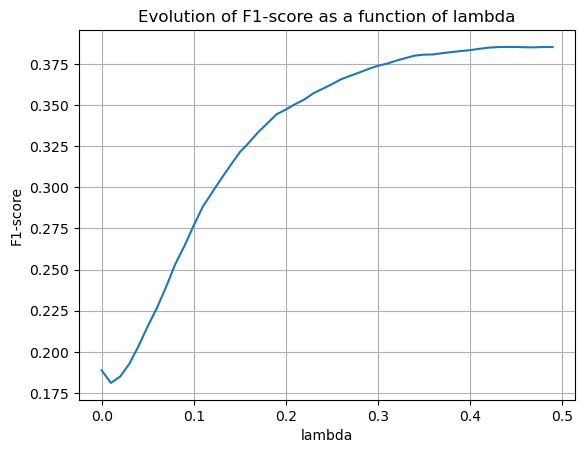

In [173]:
plt.plot(lambdas,F1_te)
plt.xlabel("lambda")
plt.ylabel("F1-score")
plt.title("Evolution of F1-score as a function of lambda")
plt.grid(True)
plt.savefig("F1-score_lambda")

### Run regularized logistic regression with best param

In [175]:
tx = build_poly(std_x_med, best_degree)

In [176]:
size_w = tx.shape[1]

In [177]:
w_reg, loss_reg = reg_logistic_regression(y_01, tx, initial_w = np.zeros(size_w), max_iters = 50, gamma = 0.5, lambda_ = best_lambda)
print(loss_reg)
y_reg = convert_0_to_minus1(convert_predict(tx @ w_reg))
print(y_reg)
# accuracy
p_reg = compute_accuracy(y_train, y_reg) #percentage of false predictions
print(p_reg)

0.5381353710565024
[-1. -1. -1. ... -1. -1. -1.]
0.869876727566398


In [178]:
tx_test = build_poly(std_test_med, best_degree)
y_pred = convert_0_to_minus1(convert_predict(tx_test @ w_reg))

In [179]:
create_csv_submission(test_ids, y_pred, "new_result")

### F1-score of all methods without hyperparameter finetuning

In [190]:
# GD
w_mse_gd, loss_mse_gd = mean_squared_error_gd(y_01, std_x_med, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
y_mse_gd = convert_predict(std_x_med @ w_mse_gd)
print(f"The F1-score is: {compute_f1(y_01,y_mse_gd)}")

The F1-score is: 0.295541577862106


In [194]:
# SGD
w_mse_sgd, loss_mse_sgd = mean_squared_error_sgd(y_01, std_x_med, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
y_mse_sgd = convert_predict(std_x_med @ w_mse_sgd)
print(f"The F1-score is: {compute_f1(y_01,y_mse_sgd)}")

The F1-score is: 0.1915857944709647


In [184]:
# Least squares
w_ls, loss_ls = least_squares(y_01, std_x_med)
y_ls = convert_predict(std_x_med @ w_ls)
print(f"The F1-score is: {compute_f1(y_01,y_ls)}")

The F1-score is: 0.32027667187421255


In [185]:
# Ridge regression
w_rr, loss_rr = ridge_regression(y_01, std_x_med, lambda_ = 0.5)
y_rr = convert_predict(std_x_med @ w_rr)
print(f"The F1-score is: {compute_f1(y_01,y_rr)}")

The F1-score is: 0.30788073367222574


In [191]:
# logistic regression (GD)
w_lrgd, loss_lrgd = logistic_regression(y_01, std_x_med, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
y_lrgd = convert_predict(std_x_med @ w_lrgd)
print(f"The F1-score is: {compute_f1(y_01,y_lrgd)}")
#log sgd
#w_lrsgd, loss_lrsgd = logistic_regression_SGD(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)

The F1-score is: 0.2943724944256386


In [193]:
w_reg, loss_reg = reg_logistic_regression(y_01, std_x_med, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001, lambda_ = 0.5)
y_reg = convert_predict(std_x_med @ w_reg)
print(f"The F1-score is: {compute_f1(y_01,y_reg)}")
# reg log sgd
#w_reg_lrsgd, loss_reg_lrsgd = reg_logistic_regression_SGD(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)

The F1-score is: 0.2943724944256386


### Create a csv file with a prediction

In [ ]:
# predict y with x_test using regularized log
y_pred = convert_0_to_minus1(convert_predict(standardized_test @ w_reg))
print(y_pred)

In [ ]:
create_csv_submission(test_ids, y_pred, "submission")

### OLD VERSION:

Take care of the NaNs

In [ ]:
nb_nans = np.zeros(nb_col)
for i, col in enumerate(x_train.T):
    nb_nans[i] = np.count_nonzero(np.isnan(col))
plt.figure(figsize=(10, 5))
plt.hist(nb_nans, bins=20)
plt.title("Number of NaNs per feature before")


In [ ]:
reduced_x_train, reduced_ids = removing_features(nb_nans, train_ids, x_train)

for i, col in enumerate(reduced_x_train.T):
    nb_nans[i] = np.count_nonzero(np.isnan(col))
plt.figure(figsize=(10, 5))
plt.hist(nb_nans, bins=20)
plt.title("Number of NaNs per feature after")

Standardize and remove nans

In [ ]:
# remove the columns that have the same value in it (avoid std=0)
reduced_x_train, reduced_ids = remove_identic_col(reduced_ids, reduced_x_train)
nb_col_reduced = reduced_x_train.shape[1]
print(nb_col_reduced)

In [ ]:
x_standardized = standardize_data(reduced_x_train)

clean_x_train = replace_NaN(x_standardized, method = 'mean')

## Run the methods a first time to see how we're doing

In [ ]:
from implementations import *
NB_COL = clean_x_train.shape[1] # corresponds to 'D' = number of features
NB_ROWS = clean_x_train.shape[0] # corresponds to 'N' = number of observations/respondents

### Gradient descent

In [ ]:
w_mse_gd, loss_mse_gd = mean_squared_error_gd(y_train, clean_x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
print(loss_mse_gd)
y_mse_gd = clean_x_train @ w_mse_gd
y_mse_gd = convert_predict(y_mse_gd)
print(y_mse_gd)

In [ ]:
print(y_train)

### Subgradient descent

In [ ]:
w_mse_sgd, loss_mse_sgd = mean_squared_error_sgd(y_train, clean_x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
print(loss_mse_gd)
y_mse_gd = clean_x_train @ w_mse_gd
y_mse_gd = convert_predict(y_mse_gd)
print(y_mse_gd)

In [ ]:
w_ls, loss_ls = least_squares(y_train, x_train)
w_rr, loss_rr = ridge_regression(y_train, x_train, lambda_ = 0.5)
w_lrgd, loss_lrgd = logistic_regression(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_lrsgd, loss_lrsgd = logistic_regression_SGD(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_reg_lrgd, loss_reg_lrgd = reg_logistic_regression(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_reg_lrsgd, loss_reg_lrsgd = reg_logistic_regression_SGD(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)

Idea to remove columns: compare means in population y=0 and y=1, and remove col for which those means are close
(this is done already a little with remove_identic_col for the columns that have the same value in each cell)

Cleaning outliers

In [ ]:
removed_outlier_x_train = clean_outliers(reduced_x_train)

In [ ]:
features_below_10_unique_values = {}
for i in range(reduced_x_train.shape[1]):
    # print(f"{reduced_features[i]}: {len(np.unique(reduced_data[:,i]))}")
    #print(f"{reduced_features[i]}: {np.unique(reduced_x_train[:,i])}")
    if len(np.unique(reduced_x_train[:,i])) < 10:
        features_below_10_unique_values[reduced_features[i]] = len(np.unique(reduced_x_train[:,i]))

# dealing with correlation 

def create_dictionary_from_correlation(correlation_threshold):
    newfeature_correlation_dict = {}
    # For each feature in the dataset calculate the correlation with the others and save those which have higher than 0.6 correlation
    for ft_num, feature in enumerate(reduced_features):
        newfeature_correlation_dict[feature] = []
        for o_ft_num, other_feature in enumerate(reduced_features):
            if (feature != other_feature):
                if np.abs(np.corrcoef(reduced_x_train[:,ft_num],reduced_x_train[:,o_ft_num])[0,1]) >= correlation_threshold:
                    newfeature_correlation_dict[feature].append(other_feature)
        print(f" Finished for feature: {feature}")
    return newfeature_correlation_dict

feature_correlation_dict = create_dictionary_from_correlation(0.6)
with open('feature_correlation_dict.pickle', 'wb') as handle:
    pickle.dump(feature_correlation_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('feature_correlation_dict.pickle', 'rb') as handle:
    feature_correlation_dict = pickle.load(handle)

### Run the functions on the data

In [ ]:
from implementations import *
w_mse_gd, loss_mse_gd = mean_squared_error_gd(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1)
w_mse_sgd, loss_mse_sgd = mean_squared_error_sgd(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1)
w_ls, loss_ls = least_squares(y_train, x_train)
w_rr, loss_rr = ridge_regression(y_train, x_train, lambda_ = 0.5)
w_lrgd, loss_lrgd = logistic_regression_GD(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_lrsgd, loss_lrsgd = logistic_regression_SGD(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_reg_lrgd, loss_reg_lrgd = regularized_logistic_regression_GD(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_reg_lrsgd, loss_reg_lrsgd = regularized_logistic_regression_SGD(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1, lambda_ = 0.5)